In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('EDA').getOrCreate()

In [2]:
df = spark.read.json("../Data/utilization.json")
df.show(10)

+---------------+-------------------+-----------+---------+-------------+
|cpu_utilization|     event_datetime|free_memory|server_id|session_count|
+---------------+-------------------+-----------+---------+-------------+
|           0.57|03/05/2019 08:06:14|       0.51|      100|           47|
|           0.47|03/05/2019 08:11:14|       0.62|      100|           43|
|           0.56|03/05/2019 08:16:14|       0.57|      100|           62|
|           0.57|03/05/2019 08:21:14|       0.56|      100|           50|
|           0.35|03/05/2019 08:26:14|       0.46|      100|           43|
|           0.41|03/05/2019 08:31:14|       0.58|      100|           48|
|           0.57|03/05/2019 08:36:14|       0.35|      100|           58|
|           0.41|03/05/2019 08:41:14|        0.4|      100|           58|
|           0.53|03/05/2019 08:46:14|       0.35|      100|           62|
|           0.51|03/05/2019 08:51:14|        0.6|      100|           45|
+---------------+-------------------+-

In [4]:
df.count()

500000

In [5]:
df.describe().show()

+-------+-------------------+-------------------+-------------------+------------------+------------------+
|summary|    cpu_utilization|     event_datetime|        free_memory|         server_id|     session_count|
+-------+-------------------+-------------------+-------------------+------------------+------------------+
|  count|             500000|             500000|             500000|            500000|            500000|
|   mean| 0.6205177399999957|               null|0.37912809999999864|             124.5|          69.59616|
| stddev|0.15875173872912945|               null|0.15830931278376276|14.430884120553191|14.850676696352851|
|    min|               0.22|03/05/2019 08:06:14|                0.0|               100|                32|
|    max|                1.0|04/09/2019 01:22:46|               0.78|               149|               105|
+-------+-------------------+-------------------+-------------------+------------------+------------------+



In [6]:
df.stat.corr('cpu_utilization', 'free_memory')

-0.4704771573080754

In [7]:
df.stat.corr('session_count', 'free_memory')

-0.5008320848876573

In [11]:
df.stat.freqItems(('server_id', 'session_count')).show()

+--------------------+-----------------------+
| server_id_freqItems|session_count_freqItems|
+--------------------+-----------------------+
|[146, 137, 101, 1...|   [92, 101, 83, 95,...|
+--------------------+-----------------------+



In [14]:
df_sample = df.sample(withReplacement=False, fraction=0.05)

In [15]:
df_sample.show(10)

+---------------+-------------------+-----------+---------+-------------+
|cpu_utilization|     event_datetime|free_memory|server_id|session_count|
+---------------+-------------------+-----------+---------+-------------+
|           0.29|03/05/2019 09:16:14|        0.4|      100|           47|
|           0.49|03/05/2019 09:26:14|       0.66|      100|           65|
|           0.32|03/05/2019 11:21:14|       0.47|      100|           48|
|           0.66|03/05/2019 11:31:14|        0.6|      100|           56|
|           0.67|03/05/2019 12:26:14|        0.6|      100|           66|
|            0.4|03/05/2019 13:21:14|       0.55|      100|           43|
|           0.29|03/05/2019 13:36:14|       0.63|      100|           67|
|           0.45|03/05/2019 14:11:14|       0.64|      100|           67|
|           0.35|03/05/2019 20:36:14|       0.53|      100|           59|
|           0.53|03/05/2019 21:41:14|        0.6|      100|           42|
+---------------+-------------------+-

In [16]:
df_sample.count()

24669

In [17]:
df.createOrReplaceTempView('utilization')

In [20]:
spark.sql("""SELECT min(cpu_utilization), max(cpu_utilization), stddev(cpu_utilization) FROM utilization""").show()

+--------------------+--------------------+----------------------------+
|min(cpu_utilization)|max(cpu_utilization)|stddev_samp(cpu_utilization)|
+--------------------+--------------------+----------------------------+
|                0.22|                 1.0|         0.15875173872912945|
+--------------------+--------------------+----------------------------+



In [24]:
spark.sql("""SELECT server_id, min(cpu_utilization), \
            max(cpu_utilization), stddev(cpu_utilization) \
            FROM utilization \
            GROUP BY server_id""").show(10)

+---------+--------------------+--------------------+----------------------------+
|server_id|min(cpu_utilization)|max(cpu_utilization)|stddev_samp(cpu_utilization)|
+---------+--------------------+--------------------+----------------------------+
|      112|                0.52|                0.92|         0.11528867845082576|
|      113|                0.58|                0.98|         0.11544345150353687|
|      130|                0.35|                0.75|         0.11568834774245991|
|      126|                0.48|                0.88|         0.11542612970702058|
|      149|                0.54|                0.94|         0.11543517500295467|
|      110|                0.35|                0.75|         0.11533251724450215|
|      136|                0.41|                 0.8|         0.11597405743182258|
|      144|                0.47|                0.87|         0.11478654960489501|
|      119|                0.22|                0.62|         0.11516031929842008|
|   

#### bucketting

In [28]:
df_bucket = spark.sql("""SELECT COUNT(*) AS total_count, FLOOR(cpu_utilization*100/10) AS bucket \
                FROM utilization GROUP BY bucket ORDER BY bucket""")

In [29]:
df_bucket.show()

+-----------+------+
|total_count|bucket|
+-----------+------+
|       8186|     2|
|      37029|     3|
|      68046|     4|
|     104910|     5|
|     116725|     6|
|      88242|     7|
|      56598|     8|
|      20207|     9|
|         57|    10|
+-----------+------+



In [30]:
df_bucket_pandas = df_bucket.toPandas()

In [31]:
import matplotlib.pyplot as plt

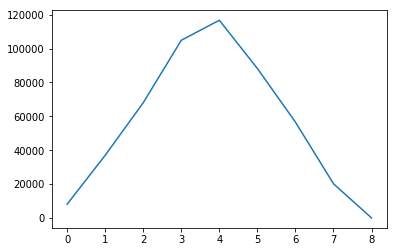

In [43]:
df_bucket_pandas["total_count"].plot(kind = "line");

#### windows functions

In [46]:
spark.sql("""SELECT * FROM utilization""").show(10)

+---------------+-------------------+-----------+---------+-------------+
|cpu_utilization|     event_datetime|free_memory|server_id|session_count|
+---------------+-------------------+-----------+---------+-------------+
|           0.57|03/05/2019 08:06:14|       0.51|      100|           47|
|           0.47|03/05/2019 08:11:14|       0.62|      100|           43|
|           0.56|03/05/2019 08:16:14|       0.57|      100|           62|
|           0.57|03/05/2019 08:21:14|       0.56|      100|           50|
|           0.35|03/05/2019 08:26:14|       0.46|      100|           43|
|           0.41|03/05/2019 08:31:14|       0.58|      100|           48|
|           0.57|03/05/2019 08:36:14|       0.35|      100|           58|
|           0.41|03/05/2019 08:41:14|        0.4|      100|           58|
|           0.53|03/05/2019 08:46:14|       0.35|      100|           62|
|           0.51|03/05/2019 08:51:14|        0.6|      100|           45|
+---------------+-------------------+-

In [58]:
spark.sql("""SELECT event_datetime, server_id, cpu_utilization, avg(cpu_utilization) \
            OVER(PARTITION BY server_id) AS avg_utilization, 
            cpu_utilization - avg(cpu_utilization) \
            OVER(PARTITION BY server_id) AS delta_server_utilization
            FROM utilization""").show(10)

+-------------------+---------+---------------+------------------+------------------------+
|     event_datetime|server_id|cpu_utilization|   avg_utilization|delta_server_utilization|
+-------------------+---------+---------------+------------------+------------------------+
|03/05/2019 08:06:34|      112|           0.71|0.7153870000000067|    -0.00538700000000...|
|03/05/2019 08:11:34|      112|           0.78|0.7153870000000067|     0.06461299999999337|
|03/05/2019 08:16:34|      112|           0.87|0.7153870000000067|     0.15461299999999334|
|03/05/2019 08:21:34|      112|           0.82|0.7153870000000067|      0.1046129999999933|
|03/05/2019 08:26:34|      112|           0.62|0.7153870000000067|    -0.09538700000000666|
|03/05/2019 08:31:34|      112|            0.9|0.7153870000000067|     0.18461299999999337|
|03/05/2019 08:36:34|      112|           0.89|0.7153870000000067|     0.17461299999999336|
|03/05/2019 08:41:34|      112|           0.81|0.7153870000000067|      0.094612